In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer

avoiding unneccessary warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")

reading the file 

In [ ]:
cancer_data = pd.read_csv('/content/drive/MyDrive/lungcancer_patient_datasets.csv')
cancer_data.drop(["index", "Patient Id","Age"], axis=1, inplace = True)
cancer_data.head(5)

data cleaning & visualisation

In [ ]:
cancer_data.isnull().sum()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

finding & counting the dataset

In [ ]:
find_features = cancer_data.columns.tolist()[:-1]  
print("Features:", find_features)
count_features = len(cancer_data.columns)-1
print("Number of features in the dataset:", count_features)

In [ ]:
cancer_data.dtypes #datatypes

In [ ]:
cancer_data['Level'].value_counts() #cancer risk count

In [ ]:
cancer_data['Level'].replace(to_replace = 'Low', value = 0, inplace = True)
cancer_data['Level'].replace(to_replace = 'Medium', value = 1, inplace = True)
cancer_data['Level'].replace(to_replace = 'High', value = 2, inplace = True)

cancer_data['Level'].value_counts()

checking for missing values like whether data is available or not for all labels

In [ ]:
if cancer_data.isnull().values.any():
    print('Missing values are present')
else:
    print('No missing values')

Feature distribution

In [ ]:
cancer_data.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

targetting the specific values

In [ ]:
cancer_data.Level.unique()

correlation among data

In [ ]:
# compute correlation matrix
corr_matrix = cancer_data.corr()
corr_matrix

box plot against the levels

In [ ]:
fig,ax = plt.subplots(nrows = 8, ncols=3, figsize=(30,30))
row = 0
col = 0
for i in range(len(cancer_data.columns)-1):
    if col > 2:
        row += 1
        col = 0
    axes = ax[row,col]
    sns.boxplot(x = cancer_data['Level'], y = cancer_data[cancer_data.columns[i]],ax = axes)
    col += 1
plt.tight_layout()
plt.show()

dividing the data

In [ ]:
X = cancer_data.drop(['Level'],axis=1)
y = cancer_data['Level']
print(X)
print(y)

Below graph shows the distribution of the "Gender" for each value of the "Level" in separate subplots of the same size.

In [ ]:
seaborn1 = sns.FacetGrid(cancer_data, col = "Level", height = 3)
seaborn1.map(sns.distplot, "Gender")

pie chart for getting the chances of lung cancer due to air pollution

In [ ]:
plt.figure(figsize = (5,5))
plt.title("Lung Cancer Chances Due to Air Polution")
plt.pie(cancer_data['Level'].value_counts(), explode = (0.1, 0.02, 0.02), labels = ['High', 'Medium', 'Low'], autopct = "%1.2f%%", shadow = True)
plt.legend(title = "Lung Cancer rates", loc = "lower left")

splitting the data for training and testing 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 50)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
# print(X_val)

normalize the data

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Tuning the hyperparameters

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the MLPClassifier model
mlp = MLPClassifier()

# Define the hyperparameters to be tuned
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'random_state': [42,32,50]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the performance of the model on the testing set
accuracy = grid_search.score(X_test, y_test)
print("Accuracy on testing set:", accuracy)

Training the MODEL

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
mlp = MLPClassifier(hidden_layer_sizes=(100,),activation='relu', solver='adam',alpha=0.0001,learning_rate ='constant',max_iter=1000,random_state=50)
mlp.fit(X_train, y_train)
print("Output layer function:",mlp.out_activation_)
test_score = mlp.score(X_test, y_test)
print(test_score)

Output layer function: softmax
1.0


In [22]:
# fine-tune model on validation set
mlp.fit(X_val, y_val)
# evaluate fine-tuned model on validation set
val_accuracy = mlp.score(X_val, y_val)
print("Validation accuracy after fine-tuning:", val_accuracy)

Validation accuracy after fine-tuning: 1.0


In [23]:
# fine-tune model on test set
mlp.fit(X_test, y_test)
# evaluate fine-tuned model on test set
test_accuracy = mlp.score(X_test, y_test)
print("test accuracy after fine-tuning:", test_accuracy)

test accuracy after fine-tuning: 1.0


prediction

In [24]:
y_pred = mlp.predict(X_test)

K-fold cross validation

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Create a KFold object with k=4 folds
kfold = KFold(n_splits=4, shuffle=True, random_state=30)

# Loop over each fold
for fold, (train_index, val_index) in enumerate(kfold.split(cancer_data)):
    # Split data into training and validation sets
    train_data = cancer_data.iloc[train_index]
    val_data = cancer_data.iloc[val_index]

    X_train = train_data.drop('Level', axis=1)
    y_train = train_data['Level']
    
    # Evaluate model on validation data
    X_val = val_data.drop('Level', axis=1)
    y_val = val_data['Level']

    # fine-tune and evaluate the performance of the model on training set
    mlp.fit(X_train, y_train)
    train_score=mlp.score(X_train, y_train)
    print("training score:",train_score)

    
    # fine-tune and evaluate the performance of the model on validation set
    mlp.fit(X_val, y_val)
    val_accuracy = mlp.score(X_val, y_val)
    print("Validation accuracy after fine-tuning:", val_accuracy)
    
    
    # fine-tune and evaluate the performance of the model on the testing set
    mlp.fit(X_test, y_test)
    test_score = mlp.score(X_test, y_test)
    print("Test accuracy after fine-tuning:",test_score)
    
    
    #Calculate the accuracy of the model predictions
    test_accuracy = accuracy_score(y_test, y_pred)

    print("Fold {}: Test accuracy: {}".format(fold+1, test_accuracy))
    print("********************\n")

training score: 1.0
Validation accuracy after fine-tuning: 1.0
Test accuracy after fine-tuning: 1.0
Fold 1: Test accuracy: 1.0
********************

training score: 1.0
Validation accuracy after fine-tuning: 1.0
Test accuracy after fine-tuning: 1.0
Fold 2: Test accuracy: 1.0
********************

training score: 1.0
Validation accuracy after fine-tuning: 1.0
Test accuracy after fine-tuning: 1.0
Fold 3: Test accuracy: 1.0
********************

training score: 1.0
Validation accuracy after fine-tuning: 1.0
Test accuracy after fine-tuning: 1.0
Fold 4: Test accuracy: 1.0
********************



Measuring the Performance

Precision :  1.0
Recall :  1.0
Accuracy :  1.0
F1 Score :  1.0

 [[102   0   0]
 [  0 105   0]
 [  0   0 123]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00       123

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330

******************************************************



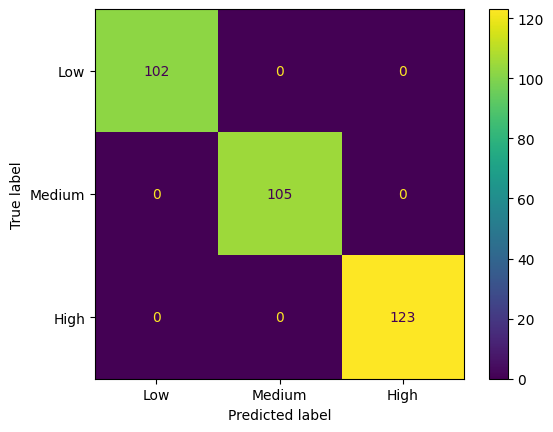

In [33]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
def perform(y_pred):
    print("Precision : ", precision_score(y_test, y_pred, average = 'micro'))
    print("Recall : ", recall_score(y_test, y_pred, average = 'micro'))
    print("Accuracy : ", accuracy_score(y_test, y_pred))
    print("F1 Score : ", f1_score(y_test, y_pred, average = 'micro'))
    cm = confusion_matrix(y_test, y_pred)
    print("\n", cm)
    print("\n")
    print("**"*27 + "\n" + " "* 16 + "Classification Report\n" + "**"*27)
    print(classification_report(y_test, y_pred))
    print("**"*27+"\n")
    
    cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Low', 'Medium', 'High'])
    cm.plot()
perform(y_pred)

Plot ROC & AUC

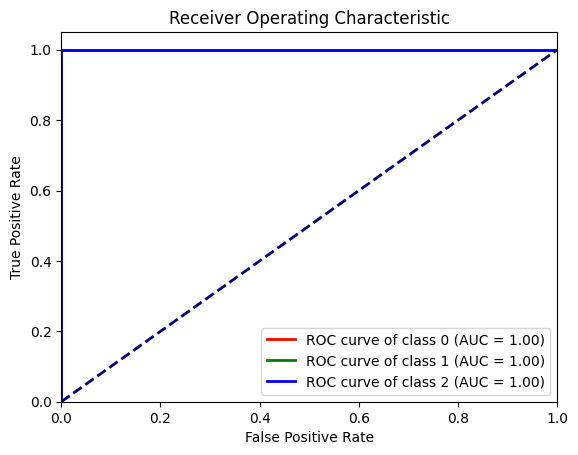

In [34]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Convert the labels to a one-hot encoded binary matrix
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
 
#Predict the probabilities for each class on the test data
y_score = mlp.predict_proba(X_test)
# Compute the ROC and AUC scores for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = ['red', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()